In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Loading the data :

In [2]:
with open("data/ownedgames.json", "r") as f :
    data = json.loads(f.read())

### Removing null entries :

In [3]:
data = {key : value for key, value in data.items() if value != {}}
data = {key : value for key, value in data.items() if value["game_count"] != 0}

### Making a DataFrame :

In [4]:
df_values = []
for key, value in data.items() :
    steamid = key
    for item in value["games"] :
        df_values.append((int(steamid), item["appid"], item["playtime_forever"]))

In [5]:
df = pd.DataFrame(df_values, columns = ["steamid", "appid", "playtime_forever"])

In [6]:
df.head()

,steamid,appid,playtime_forever
0,76561197969918174,10,3
1,76561197969918174,20,0
2,76561197969918174,30,0
3,76561197969918174,40,0
4,76561197969918174,50,0


### Removing Zero Playtime Data :
We remove the zero-playtime data for building models since we treat zero-playtime and not playing as equal. This renders smaller sized data without losing any information.

In [7]:
df = df[df["playtime_forever"] != 0]

In [8]:
df.head()

,steamid,appid,playtime_forever
0,76561197969918174,10,3
6,76561197969918174,70,57
7,76561197969918174,80,3
10,76561197969918174,220,5685
11,76561197969918174,240,35


### Density of raw data :

In [9]:
density = lambda df : len(df) / (df["steamid"].nunique() * df["appid"].nunique())

In [10]:
print("Unique SteamIds :", df["steamid"].nunique())
print("Unique AppIds :", df["appid"].nunique())
print("Density : {0:.2f} %".format(density(df) * 100))

Unique SteamIds : 15582
Unique AppIds : 21925
Density : 0.99 %


### Sampling :
Since games that have few players are not useful for recommendation, we discard such games. Similarly, players that have few games in their library are not useful for recommendation and we discard such players as well. The two criterias based on which we discard are 
1. Discard a `appid` if it has less than `c1` unique players
2. Discard a `steamid` if it has less than `c2` unique games played

We determine cutoffs `c1` and `c2` by the distribution of `steamid` counts and `appid` counts respectively. 

#### Grouping by `appid` to get player count for each `appid` :

In [11]:
groupby_appid = df.groupby(by = "appid")["steamid"].count()

#### To determine `c1`, we plot the number of `appids` against unique `steamids`. 
For example, (1, 100) corresponds to there being 100 games that have only 1 player.

In [12]:
elbow_appid = groupby_appid.groupby(groupby_appid).count()
x, y = elbow_appid.index, elbow_appid.values

In [28]:
groupby_appid.head()

appid
10    3942
20    1407
30    1111
40     713
50    1313
Name: steamid, dtype: int64

In [29]:
len(groupby_appid[groupby_appid == 1])

2371

In [22]:
elbow_appid.head()

steamid
1    2371
2    1354
3     876
4     861
5     742
Name: steamid, dtype: int64

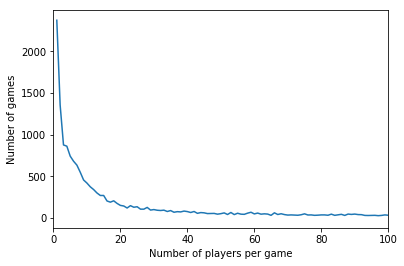

In [30]:
fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlabel("Number of players per game")
ax.set_ylabel("Number of games")
ax.set_xlim([0,100])
plt.show()

We choose `c1` = 10, based on intuition.

In [118]:
filter_appid = groupby_appid[groupby_appid > 10]

In [119]:
filter_appid_df = pd.merge(filter_appid.reset_index(), df, on = "appid").drop("steamid_x", axis = 1).rename(index = int, columns = {"steamid_y" : "steamid"})

In [120]:
filter_appid_df.head()

,appid,steamid,playtime_forever
0,10,76561197969918174,3
1,10,76561198001033415,582
2,10,76561197960794555,251
3,10,76561198053398526,211
4,10,76561197967925129,19


In [121]:
print("Unique SteamIds :", filter_appid_df["steamid"].nunique())
print("Unique AppIds :", filter_appid_df["appid"].nunique())
print("Density : {0:.2f} %".format(density(filter_appid_df) * 100))

Unique SteamIds : 15582
Unique AppIds : 12982
Density : 1.65 %


By removing sparse games, the density of the new data has improved. The unique `appids` have decreased naturally while the unique `steamids` have not decreased. We now perform a similar procedure that discards the sparse players.

In [122]:
groupby_steamid = filter_appid_df.groupby(by = "steamid").count()["appid"]

#### We plot the distribtion of `appid` counts to determine the cutoff `c2`.

In [123]:
groupby_steamid_nparr = groupby_steamid.values

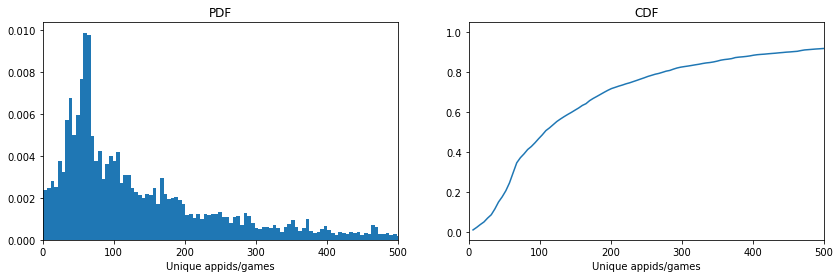

In [131]:
fig, ax = plt.subplots(ncols = 2, figsize = (14, 4))
counts, bin_edges = np.histogram(groupby_steamid_nparr, bins = 2000, density = True)
ecdf = np.cumsum(counts)
ax[0].hist(groupby_steamid_nparr, density = True, bins = 2000)
ax[0].set_xlabel("Unique appids/games")
ax[0].set_xlim([0, 500])
ax[0].set_title("PDF")
ax[1].plot(bin_edges[1:], ecdf/ecdf[-1])
ax[1].set_xlim([0, 500])
ax[1].set_xlabel("Unique appids/games")
ax[1].set_title("CDF")
plt.show()

We determine `c2` to be 65, the reason being that the distribution of `appid` counts start to increase rapidly after 65 (users with number of unique games less than 65 are rare). We want to discard such users because they are quite sparse compared to the rest of the data and result in negligible data loss but noticably increase the density.

In [132]:
filter_steamid = groupby_steamid[groupby_steamid > 35]

In [133]:
filter_steamid_df = pd.merge(filter_steamid.reset_index(), filter_appid_df, on = "steamid").drop("appid_x", axis = 1).rename(index = int, columns = {"appid_y" : "appid"})

In [134]:
print("Unique SteamIds :", filter_steamid_df["steamid"].nunique())
print("Unique AppIds :", filter_steamid_df["appid"].nunique())
print("Density : {0:.2f} %".format(density(filter_steamid_df) * 100))

Unique SteamIds : 13845
Unique AppIds : 12982
Density : 1.84 %


### Dumping the sampled data

In [135]:
#filter_steamid_df.to_csv("final_data.csv")